In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

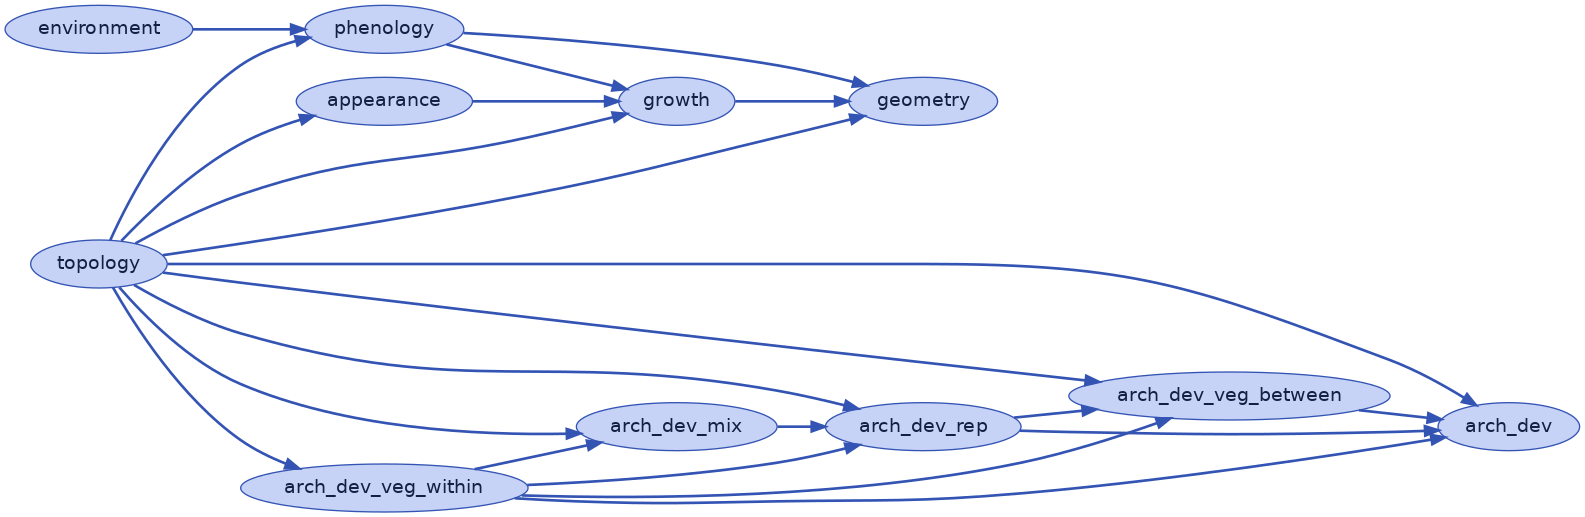

In [3]:
model.visualize()

In [4]:
nb_gus = 3
g = ig.Graph.Tree(nb_gus, 2, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

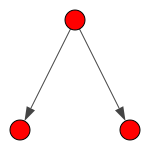

In [5]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [6]:
final_length_internodes = np.array([None] * nb_gus, dtype=object)
final_length_leaves = np.array([None] * nb_gus, dtype=object)
final_length_internodes[0] = [50]
final_length_leaves[0] = [0]
for i in range(1, nb_gus):
    final_length_internodes[i] = [40]
    final_length_leaves[i] = [0]

ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/vmango.toml',
    clocks={
        'day': pd.date_range(start='2002-04-01', end='2005-12-31', freq="1d")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'seed': 2,
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'adjacency': adjacency,
            'is_apical': np.array([1.] + ([0.] * (nb_gus - 2)) + [1.]),
            'ancestor_is_apical': np.ones(nb_gus),
            'ancestor_nature': np.full(nb_gus, Nature.VEGETATIVE),
            'appearance_month': np.array([3] + ([4] * (nb_gus - 1))),
            'appearance_date': np.array(['2002-03-01'] + (['2002-04-01'] * (nb_gus - 1))),
            'cycle': np.full(nb_gus, 2),
        },
        'geometry': {
            'sample_freq': -1
        },
        'phenology': {
            'bloom_date': np.full(nb_gus, '2002-11-01')
        },
        'arch_dev': {
            'pot_burst_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]'),
            'pot_flowering_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]'),
            'pot_has_apical_child': np.zeros(nb_gus),
            'pot_nb_lateral_children': np.zeros(nb_gus),
            'pot_nature': np.zeros(nb_gus),
            'pot_nb_inflo': np.zeros(nb_gus),
            'pot_nb_fruit': np.zeros(nb_gus)
        },
        'appearance': {
            'final_length_internodes': final_length_internodes,
            'nb_internode': np.ones(nb_gus),
            'nb_leaf': np.zeros(nb_gus),
            'final_length_gu': np.full(nb_gus, 10),
            'final_length_leaves': final_length_leaves,
            'final_length_inflos': np.full(nb_gus, None, dtype=object)
        }
    },
    output_vars=None
)

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'DO82il7wigcQY5KCjxEFnETFb', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 50, day: 1371, hour: 24)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
  * hour                                                (hour) int8 0 1 ... 23
Data variables: (12/87)
    appearance__appeared                                (GU) float64 1.0 ... 1.0
    appearance__final_length_gu                         (GU) int64 10 10 ... 15
    appearance__final_length_inflos                     (GU) object None ... ...
    appearance__final_length_internodes                 (GU) object [50] ... ...
    appearance__final_length_leaves                     (GU) object [0] ... [...
    appearance__nb_internode                            (GU) float64 1.0 ... ...
    ...                                                  ...
    topology__month_begin_veg_cycle                     int64 7
    topology__nb_descendants                            (GU) int64 48 6 ... 0 0
    topology__nb_fruit                                  (GU) float32 0.0 ... 0.0
    topology__nb_inflo                                  (GU) float32 0.0 ... 0.0
    topology__parent_is_apical                          (GU) float64 1.0 ... 0.0
    topology__seed                                      int64 2

<AxesSubplot:xlabel='topology__appearance_date'>

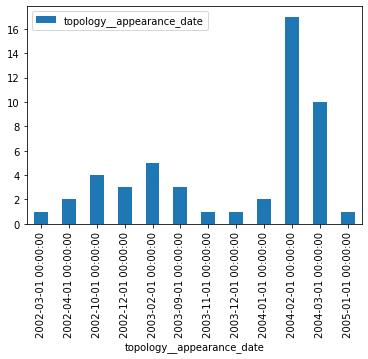

In [9]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_burst_date'>

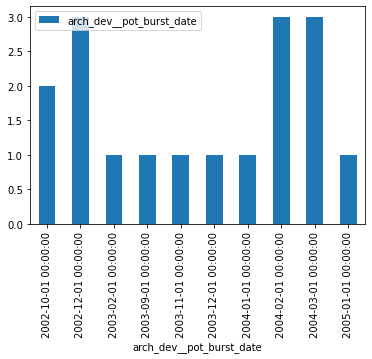

In [10]:
pot_burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
pot_burst_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev__pot_flowering_date'>

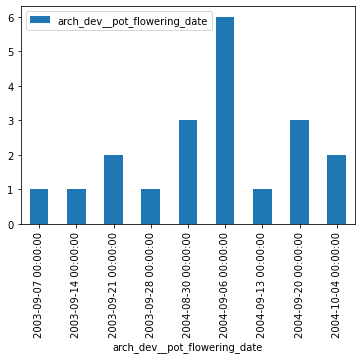

In [11]:
pot_flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
pot_flowering_date.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__nb_inflo'>

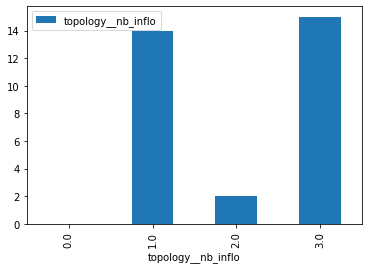

In [12]:
topology__nb_inflo = ds_out.topology__nb_inflo.groupby(ds_out.topology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__nb_fruit'>

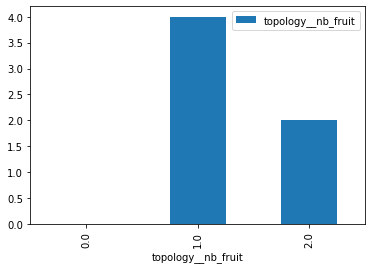

In [13]:
nb_fruit = ds_out.topology__nb_fruit.groupby(ds_out.topology__nb_fruit)
nb_fruit.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='nb_children'>

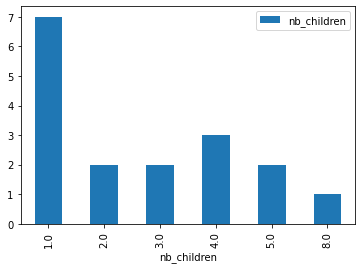

In [14]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
nb_children = nb_children[nb_children > 0]
nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

In [15]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
ds_children = xr.Dataset({
    'nb_children':  nb_children[nb_children > 0], 
    'cycle': ds_out.topology__cycle[nb_children > 0]
})
ds_children

<xarray.Dataset>
Dimensions:      (GU: 17)
Coordinates:
  * GU           (GU) <U10 'GU1' 'GU2' 'GU3' 'GU4' ... 'GU17' 'GU18' 'GU30'
Data variables:
    nb_children  (GU) float64 1.0 3.0 1.0 1.0 1.0 4.0 ... 4.0 1.0 1.0 2.0 1.0
    cycle        (GU) float32 2.0 2.0 4.0 4.0 4.0 4.0 ... 5.0 5.0 5.0 5.0 5.0

<AxesSubplot:xlabel='cycle'>

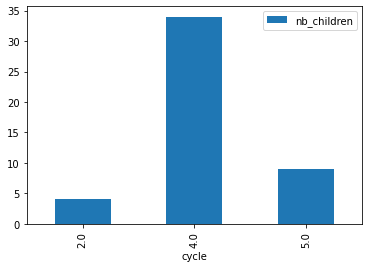

In [16]:
ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()